### TODO
1. ~~Code up VAE~~
2. ~~Code up M (RNN)~~
3. ~~Code up Train Loop for M~~
3. ~~Code up C (Controller)~~
4. ~~Set up Car Racing data for C~~
5. ~~set up car racing rollouts for VAE~~
6. ~~add in nice way to save weights and rollouts in same dir for VAE~~
6. ~~add train loop for C~~
7. ~~Get C working with VAE weights~~
9. Get C working with VAE, MDN_RNN weights
10. do on atari
11. code up baseline -> simple dqn-like thing
13. disentangling

In [1]:
import gym
import matplotlib.pyplot as plt
import torch
# # setup rendering before importing other stuff (weird hack to avoid pyglet errors)
# env = gym.make("CarRacing-v0")
# _ = env.render("rgb_array")
import numpy as np
from torch import nn
from torch.autograd import Variable
from torch.nn import functional as F
from torch.nn import init
from torch import optim
import time
from copy import deepcopy
from tqdm import tqdm


import os
import sys
if __name__ == "__main__":
    test_notebook = False
    if "ipykernel_launcher" in sys.argv[0]:
        sys.argv = [""]
        test_notebook= True

import cma
from vae import VAE
from mdn_rnn import M
from torchvision.transforms import Compose,Normalize,Resize,ToTensor
from torch.utils.data import DataLoader, Dataset
from PIL import Image
from tensorboardX import SummaryWriter

import argparse

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
Track generation: 996..1248 -> 252-tiles track


In [2]:
if __name__ == "__main__":
    parser = argparse.ArgumentParser()
    parser.add_argument("--vae_weights",type=str,default="/data/milatmp1/racaheva/models/vae_lr=0.001_rollouts=1000_batch_size=128_opt=adam/currVAE.pth")
    parser.add_argument("--mdn_rnn_weights",type=str,default="/data/milatmp1/racaheva/mdn_rnn_models/mdn_rnn_lr=0.001_opt=adam/curr_mdn_rnn.pth")
    parser.add_argument("--popsize",type=int,default=8) #64 in paper
    parser.add_argument("--routs",type=int,default=8) # 16 in paper
    parser.add_argument("--generations",type=int,default=2000)
    parser.add_argument("--eval_best_freq",type=int,default=10)
    parser.add_argument("--rollouts_for_final_eval",type=int,default=10) # paper is 100
    parser.add_argument("--nz",type=int,default=32)
    parser.add_argument("--nh",type=int,default=256)
    parser.add_argument("--env_name",type=str,default="CarRacing-v0")
    parser.add_argument("--savedir",type=str, default="/data/milatmp1/racaheva")
    parser.add_argument('--test', action='store_true')
    parser.add_argument('--zandh', action='store_true',help="use both z from vae and h from lstm")
    args = parser.parse_args()

    env = gym.make(args.env_name)
    args.__dict__["action_len"] = env.action_space.shape[0]

    basename="ctlr"
    def mkstr(key):
        d = args.__dict__
        return "=".join([key,str(d[key])])

    vae_rout_size = int(args.vae_weights.split("rollouts=")[-1].split("_")[0])
    output_dirname = "_".join([basename,mkstr("popsize"),mkstr("routs"),mkstr("zandh"),"vae_routs=%i"%(vae_rout_size)])

    if test_notebook:
        output_dirname = "notebook_" + output_dirname
        args.zandh = True
    saved_model_dir = os.path.join(args.savedir,("ctlr_models/%s" % output_dirname))
    log_dir = os.path.join(args.savedir,'.%s_logs/%s'%(basename,output_dirname))

    writer = SummaryWriter(log_dir=log_dir)

    if not os.path.exists(saved_model_dir):
        os.makedirs(saved_model_dir)

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


In [3]:
class C(nn.Module):
    def __init__(self,parameters=None):
        super(C,self).__init__()
        self.nz = args.nz
        self.nh = args.nh
        self.action_len = args.action_len
        if args.zandh:
            in_features = self.nz + self.nh
        else:
            in_features = self.nz
        self.fc = nn.Linear(in_features=in_features,out_features=self.action_len)
        if parameters is not None:
            weight_len = np.prod(self.fc.weight.size())
            weight = parameters[:weight_len]
            weight = np.resize(weight,self.fc.weight.size())
            bias = parameters[weight_len:]
            bias = np.resize(bias,self.fc.bias.size())
            self.fc.weight.set_(Variable(torch.from_numpy(weight).float()))
            self.fc.bias.set_(Variable(torch.from_numpy(bias).float()))
    
    def posprocess_output(self,raw_output):
        raw_steer, raw_gas, raw_brake = raw_output[0],raw_output[1],raw_output[2]

        steer = F.tanh(raw_steer) # between -1 and 1

        gas = F.softplus(raw_gas) # between 0 and 1

        brake = F.softplus(raw_brake) # between 0 and 1
        return steer,gas,brake
        
    
    def forward(self,z,h=None):
        
        z = z.squeeze()
        if args.zandh:
            assert (h is not None), "You must specify h, bro"
            h = h.squeeze()
            zh = torch.cat((z,h),dim=-1)
        else:
            zh = z

        raw_output = self.fc(zh)
        steer, gas, brake = self.posprocess_output(raw_output)
        action = torch.cat((steer,gas,brake))
        return action
        

In [4]:
def convert_frame(state, cuda=True):
    state = Image.fromarray(state, 'RGB')

    transforms = Compose([Resize((64,64)),ToTensor()])

    state = transforms(state)

    state = Variable(state)#.cuda()
    if cuda:
        state = state.cuda()
    return state

In [5]:
def do_rollout(ctlr):
    done= False
    reward_sum = 0.
    state = env.reset()
    _ = env.render("rgb_array")     # render must come after reset
    m.lstm.reset()
    h = m.lstm.h_prev
    while not done:
        state = convert_frame(state)
        _,_,_,z = V(state[None,:])
        a = ctlr(z,h)
        state,reward,done,_ = env.step(a.data)
        reward_sum += reward
        az = torch.cat((a[None,:],z),dim=-1)
        _,h = m.lstm(az)
    return reward_sum
    

In [6]:
def evaluate(parameters, rollouts=args.routs, negative_reward=True,dist=False):
    ctlr = C(parameters=parameters).cuda()
    solution_rewards = []
    for _ in range(rollouts):
        reward_sum = do_rollout(ctlr=ctlr)
        if negative_reward: # for cases where the cma-es library minimizes
            reward_sum = - reward_sum
        solution_rewards.append(reward_sum) 
    avg_rew = np.mean(solution_rewards)
    if dist:
        return avg_rew, np.asarray(solution_rewards)
    else:
        return avg_rew 
        
 
    

In [ ]:
if __name__ == "__main__":
    env_name="CarRacing-v0"
    m = M(batch_size=1).cuda()
    m.load_state_dict(torch.load(args.mdn_rnn_weights))
    m.eval()
    
    
    V = VAE().cuda()
    V.load_state_dict(torch.load(args.vae_weights))
    V.eval()
    
    env = gym.make(env_name)

    

    dummy_c = C()
    num_params = np.prod(dummy_c.fc.weight.size()) + np.prod(dummy_c.fc.bias.size())
    param0 = np.random.randn(num_params)
    #c= C(param0).cuda()

    es = cma.CMAEvolutionStrategy(param0, 1,inopts={"popsize":args.popsize}) #maximize
    
    prev_best_fitness = np.inf
    for generation in range(args.generations):
        params_set, fitnesses = es.ask_and_eval(evaluate)
        es.tell(params_set,fitnesses)
        best_overall_params, best_overall_fitness, _ = es.best.get()
        if best_overall_fitness < prev_best_fitness:
            best_ctlr = C(best_overall_params).cuda()
            torch.save(best_ctlr.state_dict(),'%s/best_ctlr.pth' % (saved_model_dir))
            np.savez('%s/best_ctlr_params.npz' % (saved_model_dir),params=best_overall_params)
            prev_best_fitness = best_overall_fitness
        best_perf, worst_perf, pop_mean = np.min(fitnesses), np.max(fitnesses), np.mean(fitnesses)
        writer.add_scalar("best_performer",-best_perf,global_step=generation)
        writer.add_scalar("worst_performer",-worst_perf,global_step=generation)
        writer.add_scalar("pop_mean",-pop_mean,global_step=generation)
        
        if generation % args.eval_best_freq == 0:
            best_agent_avg, best_agent_dist = evaluate(best_overall_params,rollouts=args.rollouts_for_final_eval,
                                                       negative_reward=False,dist=True)
            
            writer.add_scalar("best_agent", best_agent_avg, global_step=generation)
            writer.add_histogram("best_agent_rew_dist", best_agent_dist, global_step=generation)
            
        

In [ ]:
if __name__ == "__main__":
    #if args.test:
#         c = C().cuda()
#         c.load_state_dict(torch.load(os.path.join(saved_model_dir,"best_ctlr.pth")))
#         do_rollout(c)

    env_name="CarRacing-v0"
    m = M(batch_size=1).cuda()
    m.load_state_dict(torch.load(args.mdn_rnn_weights))
    m.eval()
    
    
    V = VAE().cuda()
    V.load_state_dict(torch.load(args.vae_weights))
    V.eval()
    
    env = gym.make(env_name)
    basedir = "/data/milatmp1/racaheva/ctlr_models/ctlr_popsize=8_routs=8_zandh=False_vae_routs=1000/"
    params = np.load(os.path.join(basedir,"best_ctlr_params.npz"))["params"]
    best_agent_avg, best_agent_dist = evaluate(params,rollouts=100,
                                                   negative_reward=False,dist=True)                
                       
                          
                          
                          

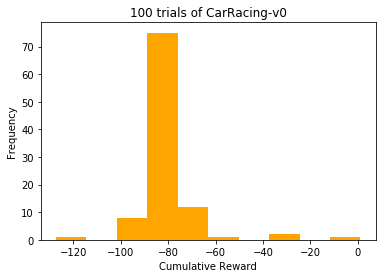

In [25]:
    best_agent_avg

    np.std(best_agent_dist)

    plt.hist(best_agent_dist,color="orange")

    plt.title("100 trials of CarRacing-v0")
    plt.xlabel("Cumulative Reward")
    plt.ylabel("Frequency")

    plt.show()

In [18]:
if __name__ == "__main__":
    env_name="CarRacing-v0"
    m = M(batch_size=1).cuda()
    m.load_state_dict(torch.load(args.mdn_rnn_weights))
    m.eval()
    
    
    V = VAE().cuda()
    V.load_state_dict(torch.load(args.vae_weights))
    V.eval()
    
    env = gym.make(env_name)
    basedir = "/data/milatmp1/racaheva/ctlr_models/ctlr_popsize=64_routs=16_zandh=False_vae_routs=1000/"
    zparams = np.load(os.path.join(basedir,"best_ctlr_params.npz"))["params"]
    zbest_agent_avg, zbest_agent_dist = evaluate(params,rollouts=100,
                                                   negative_reward=False,dist=True)                
                       
                          
                          
                          

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
Track generation: 1192..1494 -> 302-tiles track
Track generation: 1136..1424 -> 288-tiles track
Track generation: 1048..1314 -> 266-tiles track
Track generation: 1079..1353 -> 274-tiles track
Track generation: 1166..1462 -> 296-tiles track
Track generation: 1105..1385 -> 280-tiles track
Track generation: 1158..1452 -> 294-tiles track
Track generation: 1228..1539 -> 311-tiles track
Track generation: 1275..1598 -> 323-tiles track
Track generation: 1233..1552 -> 319-tiles track
Track generation: 1123..1408 -> 285-tiles track
Track generation: 1208..1514 -> 306-tiles track
Track generation: 1053..1326 -> 273-tiles track
Track generation: 1142..1431 -> 289-tiles track
Track generation: 1009..1273 -> 264-tiles track
Track generation: 1115..1399 -> 284-tiles track
Track generation: 1152..1444 -> 292-tiles track
Track generation: 1259..1578 -> 319-tiles track
Track generation: 1038..1301 -> 263-t

-82.4684233052
14.2075165755


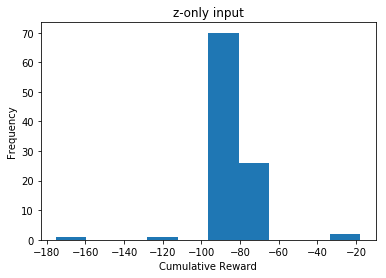

In [20]:
    print(zbest_agent_avg)

    print(np.std(zbest_agent_dist))

    plt.hist(zbest_agent_dist)

    plt.title("z-only input")
    plt.xlabel("Cumulative Reward")
    plt.ylabel("Frequency")

    plt.show()